In [1]:
%matplotlib inline
import cv2
from scipy import ndimage
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 240
plt.rcParams['savefig.dpi'] = 114

Импорт кадра из датасета


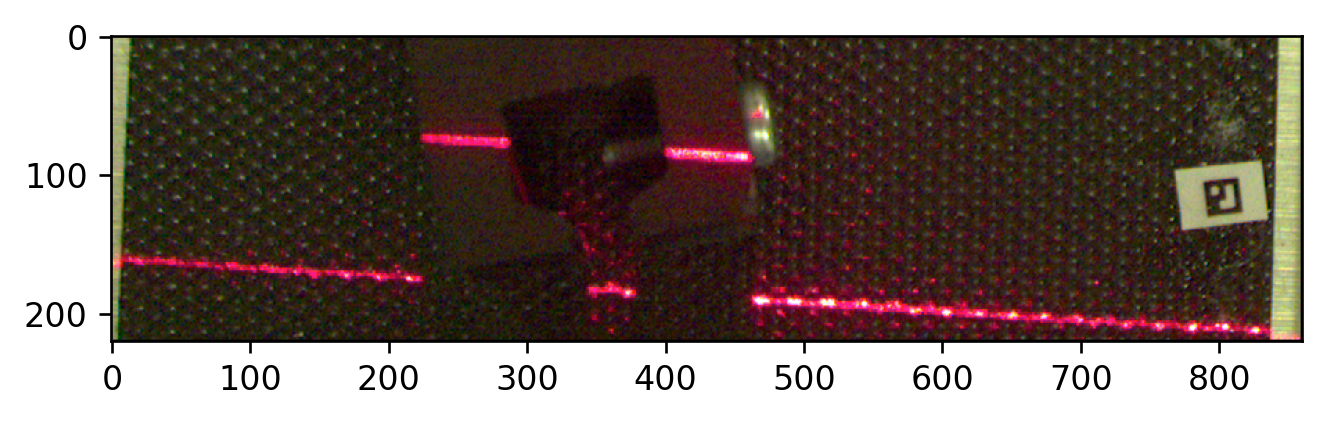

In [255]:
img = cv2.imread("./dataset/img_scan500.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pass

Выравнивание гистограммы

In [209]:
def apply_hist_equalization(img, *, clip_limit, grid_size, is_rgb=False):
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB if is_rgb else cv2.COLOR_BGR2LAB)
    lightness, *ab = cv2.split(img_lab)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    lightness_equalized = clahe.apply(lightness)

    img_lab = cv2.merge((lightness_equalized, *ab))
    img_res = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB if is_rgb else cv2.COLOR_LAB2BGR)
    return img_res

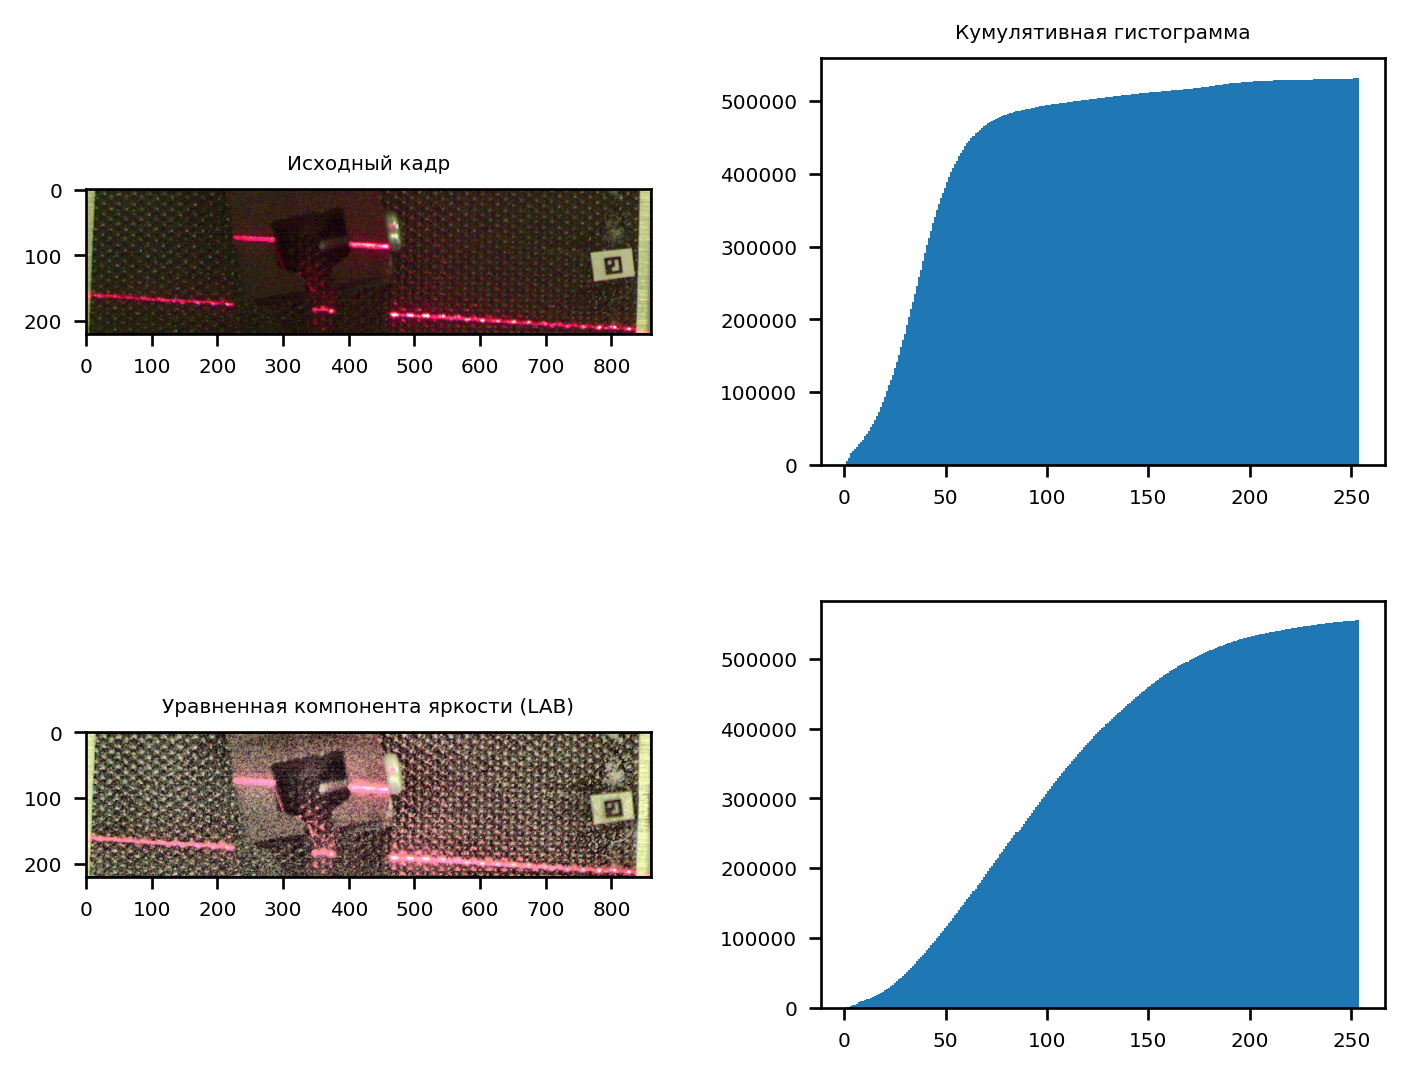

In [257]:
img_equalized = apply_hist_equalization(img, clip_limit=5, grid_size=(8, 8), is_rgb=True)

fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=2.0)
(ax_intense, ax_orig_hist), (ax_equalized, ax_equalized_hist) = axs

ax_intense.imshow(img)
ax_intense.set_title("Исходный кадр", fontsize=6)
ax_intense.tick_params(axis="x", labelsize=6)
ax_intense.tick_params(axis="y", labelsize=6)

ax_orig_hist.hist(img.ravel(), 256, range=[1, 254], cumulative=True)
ax_orig_hist.set_title("Кумулятивная гистограмма", fontsize=6)
ax_orig_hist.tick_params(axis="x", labelsize=6)
ax_orig_hist.tick_params(axis="y", labelsize=6)

ax_equalized.imshow(img_equalized)
ax_equalized.set_title("Уравненная компонента яркости (LAB)", fontsize=6)
ax_equalized.tick_params(axis="x", labelsize=6)
ax_equalized.tick_params(axis="y", labelsize=6)

ax_equalized_hist.hist(img_equalized.ravel(), 256, range=[1, 254], cumulative=True)
ax_equalized_hist.tick_params(axis="x", labelsize=6)
ax_equalized_hist.tick_params(axis="y", labelsize=6)

Подготовка изображения


In [247]:
def apply_pix_sqr_with_norm_ch(channel):
    def process_line(line):
        line = np.square([int(x) for x in line])
        minimum, delta = np.min(line), np.max(line) - np.min(line) or 1
        return np.array(
            [255 * ((x - minimum) / delta) for x in line],
            dtype=np.uint8,
        )

    return np.array([process_line(line) for line in channel], dtype=np.uint8)


def apply_pix_sqr_with_norm(img):
    red_channel, *_ = cv2.split(img)
    res = apply_pix_sqr_with_norm_ch(red_channel)
    return cv2.merge(np.array([res] * 3))

In [ ]:
from functools import reduce


def hist_equalization_process(img):
    return apply_hist_equalization(img, clip_limit=3, grid_size=(8, 8), is_rgb=True)


def blur_process(img):
    return cv2.GaussianBlur(img, (3, 3), 0)


def pix_sqr_and_norm_process(img):
    return apply_pix_sqr_with_norm(img)


def threshold_filter_process(img):
    return cv2.bitwise_and(
        img,
        img,
        mask=cv2.inRange(
            img,
            np.array([150, 20, 20]),
            np.array([255, 255, 255]),
        ),
    )


def erode_dilate_process(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 2))
    img_eroded = cv2.erode(img, kernel)
    img_dilated = cv2.dilate(img_eroded, kernel)
    return img_dilated

Этапы подготовки кадра

In [259]:
# Конвеер обработки
def prepare_image(img):
    return reduce(
        lambda stages, process: stages + [process(stages[-1])],
        (
            # Выравнивание гистограммы
            hist_equalization_process,
            # Фильтр размытия по Гауссу
            blur_process,
            # Пороговый фильтр
            threshold_filter_process,
            # Сжатие / Расширение
            erode_dilate_process,
            # Возведение пикселей в квадрат + нормализация
            lambda img: img,  # pix_sqr_and_norm_process,
            # Результат
            lambda img: img,
        ),
        [img],
    )


(
    img_orig,
    img_hist_equalized,
    img_blurred,
    img_filtered,
    img_eroded_dilated,
    img_hacked,
    img_prepared,
) = prepare_image(img)

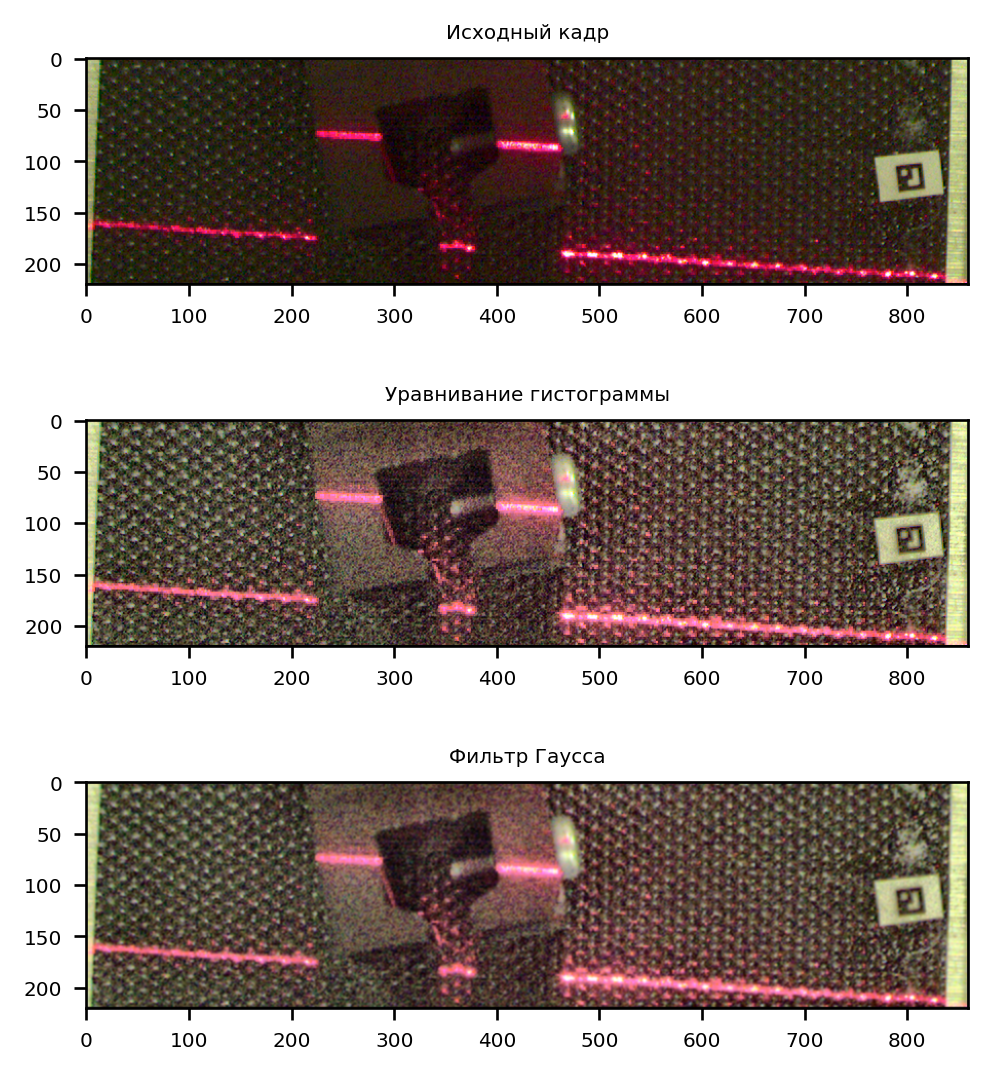

In [260]:
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=2.0)
ax_intense, ax_hist_equalized, ax_blured = axs

ax_intense.imshow(img)
ax_intense.set_title("Исходный кадр", fontsize=6)
ax_intense.tick_params(axis="x", labelsize=6)
ax_intense.tick_params(axis="y", labelsize=6)

ax_hist_equalized.imshow(img_hist_equalized)
ax_hist_equalized.set_title("Уравнивание гистограммы", fontsize=6)
ax_hist_equalized.tick_params(axis="x", labelsize=6)
ax_hist_equalized.tick_params(axis="y", labelsize=6)

ax_blured.imshow(img_blurred)
ax_blured.set_title("Фильтр Гаусса", fontsize=6)
ax_blured.tick_params(axis="x", labelsize=6)
ax_blured.tick_params(axis="y", labelsize=6)

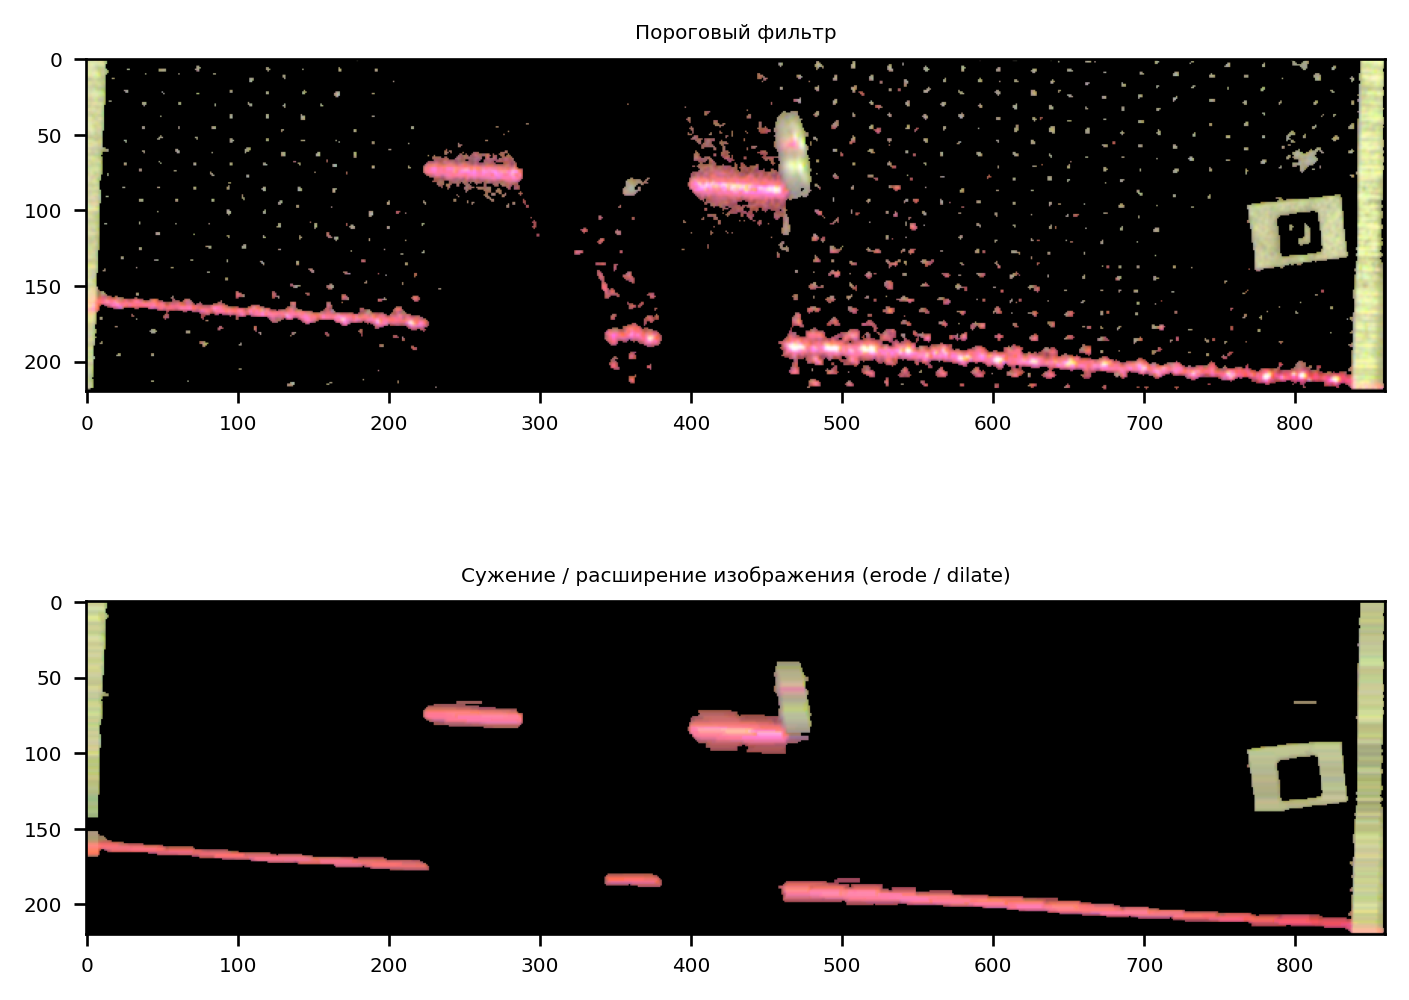

In [261]:
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=2.0)
ax_threshold, ax_eroded_dilated = axs

ax_threshold.imshow(img_filtered)
ax_threshold.set_title("Пороговый фильтр", fontsize=6)
ax_threshold.tick_params(axis="x", labelsize=6)
ax_threshold.tick_params(axis="y", labelsize=6)

# ax_hacked.imshow(img_hacked)
# ax_hacked.set_title("Квадрат пикселей", fontsize=6)
# ax_hacked.tick_params(axis="x", labelsize=6)
# ax_hacked.tick_params(axis="y", labelsize=6)

ax_eroded_dilated.imshow(img_eroded_dilated)
ax_eroded_dilated.set_title(
    "Сужение / расширение изображения (erode / dilate)", fontsize=6
)
ax_eroded_dilated.tick_params(axis="x", labelsize=6)
ax_eroded_dilated.tick_params(axis="y", labelsize=6)

Расчет нормализованной интенсивности одной вертикальной строки изображения


In [252]:
def calc_intense_norm(line: np.ndarray[np.uint8], y_min=0):
    data = np.array([[0]] * y_min + list(line[y_min:]))
    minimum, delta = np.min(data), np.max(data) - np.min(data) or 1
    return np.array([(x - minimum) / delta for x in data])

In [ ]:
def calc_intense_accurate(line: np.ndarray[np.uint8]):
    def f_gauss(
        x: np.ndarray, a: float, mu: float, sigma: float, b: float
    ) -> np.ndarray:
        return (a / sigma / np.sqrt(2 * np.pi)) * np.exp(
            -0.5 * ((x - mu) / sigma) ** 2
        ) + b

    y = calc_intense_norm(line)

    xmin, xmax = 0, len(y)
    x = np.linspace(xmin, xmax, xmax - xmin)
    i_max = y.argmax()
    ymax = y[i_max]
    mu0 = x[i_max]
    b0 = y.mean()

    i_half = np.argmax(y >= (ymax + b0) / 2)
    sigma0 = (mu0 - x[i_half]) / np.sqrt(2 * np.log((ymax - b0) / (y[i_half] - b0)))

    if np.isnan(sigma0):
        return y

    a0 = (ymax - b0) * sigma0 * np.sqrt(2 * np.pi)
    a0 = sigma0 * np.sqrt(2 * np.pi)
    p0 = a0, mu0, sigma0, b0

    # mu0 = x[i_max]  # y.mean()
    # a0 = (y - y.min()) / (y.max() - y.min()) * sigma0 / np.sqrt(2 * np.pi)
    # b0 = y.mean()
    # sigma0 = sum([(x**2) for x in y]) / len(y)
    # sigma0 = (mu0 - x[i_half]) / np.sqrt(2 * np.log((ymax - b0) / (y[i_half] - b0)))
    # p0 = a0, mu0, sigma0, b0

    return f_gauss(x, *p0)

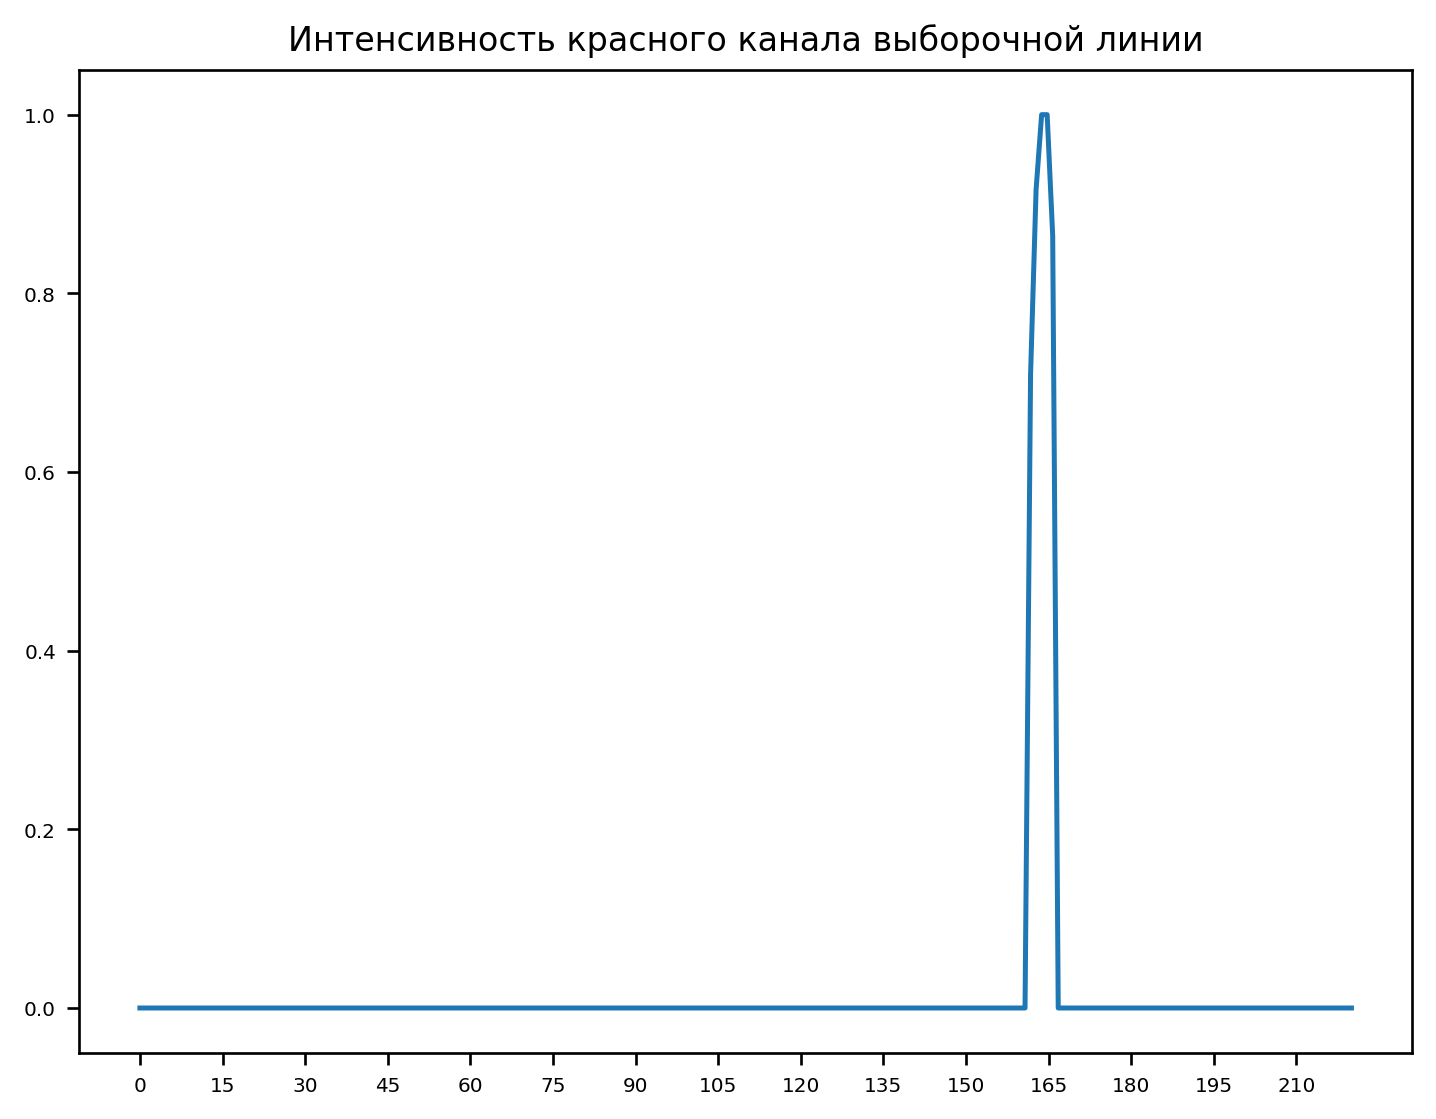

In [253]:
red_line, _, _ = cv2.split(img_prepared[:, 40:41])
y_orig = calc_intense_norm(red_line)
x = np.linspace(0, len(y_orig), len(y_orig))

fig, ax_intense = plt.subplots(1, 1)
fig.tight_layout(pad=1.5)

ax_intense.plot(x, y_orig)
ax_intense.set_title("Интенсивность красного канала выборочной линии", fontsize=10)
ax_intense.get_xaxis().set_ticks(np.arange(0, len(x), 15))
ax_intense.tick_params(axis="x", labelsize=6)
ax_intense.tick_params(axis="y", labelsize=6)

In [192]:
from scipy.signal import medfilt


def generate_laser_coords(f, *, img, intense_delta_thr=0.5):
    _, width, _ = img.shape
    return tuple(f(x, img=img, intense_delta_thr=intense_delta_thr) for x in range(width))


def generate_smooth_coords(coords, window_size=7):
    return medfilt(coords, window_size)


def fill_image(img, rgb_color, coords):
    for x, y in enumerate(coords):
        if y >= 0:
            img[y, x] = rgb_color
    return img


def create_blank_image(height, width):
    img = np.zeros((height, width, 3), np.uint8)
    img[::] = (255, 255, 255)
    return img

In [193]:
def f(x, *, img, intense_delta_thr=0.5):
    # Извлечь вертикальную линию по x
    vert_line = img[:, x : x + 1]
    # Выделить красный канал
    r_channel = cv2.split(vert_line)[0]
    # Расчитать нормализованную интенсивность
    values = calc_intense_norm(r_channel)
    # Вернуть пик интенсивности
    y = np.argmax(values)
    return y if (np.max(values) - np.mean(values)) > intense_delta_thr else -1

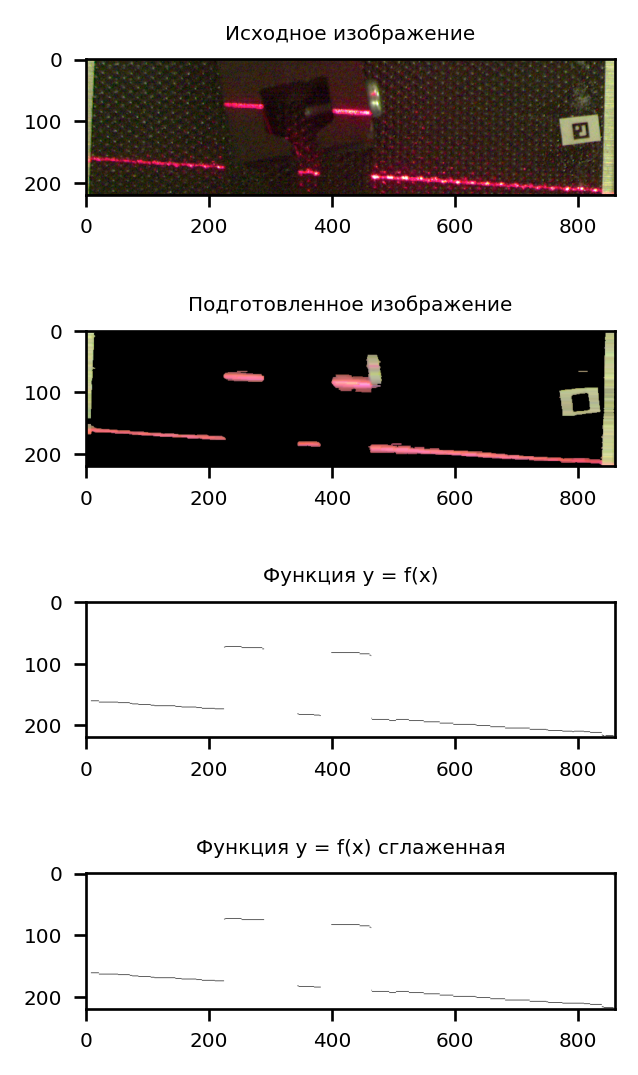

In [254]:
fig, axs = plt.subplots(4, 1)
fig.tight_layout(pad=2.0)
ax_intense, ax_prepared, ax_laser, ax_laser_smooth = axs

ax_intense.imshow(img)
ax_intense.set_title("Исходное изображение", fontsize=6)
ax_intense.tick_params(axis="x", labelsize=6)
ax_intense.tick_params(axis="y", labelsize=6)

ax_prepared.imshow(img_prepared)
ax_prepared.set_title("Подготовленное изображение", fontsize=6)
# ax_prepared.get_xaxis().set_ticks(np.arange(0, len(y), 100))
ax_prepared.tick_params(axis="x", labelsize=6)
ax_prepared.tick_params(axis="y", labelsize=6)

height, width, _ = img.shape
ax_laser.imshow(
    fill_image(
        create_blank_image(height, width),
        (0, 0, 0),
        generate_laser_coords(f, img=img_prepared, intense_delta_thr=0.5),
    )
)
ax_laser.set_title("Функция y = f(x)", fontsize=6)
ax_laser.tick_params(axis="x", labelsize=6)
ax_laser.tick_params(axis="y", labelsize=6)

ax_laser_smooth.imshow(
    fill_image(
        create_blank_image(height, width),
        (0, 0, 0),
        generate_smooth_coords(
            generate_laser_coords(f, img=img_prepared, intense_delta_thr=0.5),
            window_size=7,
        ),
    )
)
ax_laser_smooth.set_title("Функция y = f(x) сглаженная", fontsize=6)
ax_laser_smooth.tick_params(axis="x", labelsize=6)
ax_laser_smooth.tick_params(axis="y", labelsize=6)
pass

Вывод датасета в видеопоток

In [200]:
import os
import re

files = os.listdir("./dataset")
tpls = []
for file in files:
    m = re.match("img_scan(\d+)", file)
    tpls += [(int(m.group(1)), m.group(0))]

filenames = [filename for _, filename in sorted(tpls)]

In [201]:
def process(img):
    img_prepared, *_ = prepare_image(img)
    return fill_image(
        create_blank_image(height, width),
        (0, 0, 0),
        generate_smooth_coords(
            generate_laser_coords(f, img=img_prepared, intense_delta_thr=0.6), window_size=21
        ),
    )

In [202]:
writer = cv2.VideoWriter()
writer.open("./output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (860, 440))
for filename in filenames:
    orig_frame = cv2.imread(f"./dataset/{filename}.png")
    frame = cv2.vconcat(
        [orig_frame, process(cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB))]
    )
    writer.write(frame)
writer.release()

[ WARN:0@11461.944] global cap.cpp:781 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.11.0) /private/var/folders/v2/nrrmp88d7ss2dtc937jx67w40000gn/T/pip-install-4nzlgjbh/opencv-python_a2588345ef374e8db5443eacc7d0ba28/opencv/modules/videoio/src/cap_images.cpp:415: error: (-215:Assertion failed) !filename_pattern.empty() in function 'CvVideoWriter_Images'




KeyboardInterrupt: 